In [ ]:
!pip install d2l==0.14.4

     |████████████████████████████████| 61kB 1.8MB/s 


In [ ]:
#This code was used for section7.5.8 in its entirety, and is modifiable for 
#each of the problems with ease.
from d2l import tensorflow as d2l
import tensorflow as tf
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    inv *= gamma
    Y = X * inv + (beta - moving_mean * inv)
    return Y

class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        weight_shape = [input_shape[-1], ]
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
            initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
            initializer=tf.initializers.zeros, trainable=True)
        self.moving_mean = self.add_weight(name='moving_mean',
            shape=weight_shape, initializer=tf.initializers.zeros,
            trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance',
            shape=weight_shape, initializer=tf.initializers.zeros,
            trainable=False)
        super(BatchNorm, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        momentum = 0.9
        delta = variable * momentum + value * (1 - momentum)
        return variable.assign(delta)

    @tf.function
    def call(self, inputs, training):
        if training:
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(
                inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            batch_mean = tf.squeeze(batch_mean, axes)
            batch_variance = tf.squeeze(batch_variance, axes)
            mean_update = self.assign_moving_average(
                self.moving_mean, batch_mean)
            variance_update = self.assign_moving_average(
                self.moving_variance, batch_variance)
            self.add_update(mean_update)
            self.add_update(variance_update)
            mean, variance = batch_mean, batch_variance
        else:
            mean, variance = self.moving_mean, self.moving_variance
        output = batch_norm(inputs, moving_mean=mean, moving_var=variance,
            beta=self.beta, gamma=self.gamma, eps=1e-5)
        return output
dropout1, dropout2, dropout3, dropout4 = 0.1, 0.2,0.3,0.4
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(28, 28, 1)),
        #BatchNorm(),
        tf.keras.layers.Dropout(dropout1),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        #BatchNorm(),
        tf.keras.layers.Dropout(dropout2),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        #BatchNorm(),
        tf.keras.layers.Dropout(dropout3),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        tf.keras.layers.Dropout(dropout4),
        #BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(10)]
    )



In [ ]:
lr, num_epochs, batch_size = .4, 15, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss 0.663, train acc 0.741, test acc 0.745
2575.2 examples/sec on /CPU:0


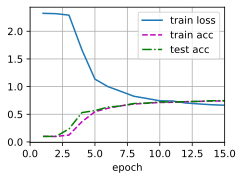

In [ ]:
net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)
